In [3]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as pl
import numpy as np
import shap
import ssl

In [8]:
ssl._create_default_https_context= ssl._create_unverified_context

In [5]:
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()

In [ ]:
model = VGG16()

In [14]:
!wget 'https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all&w=782' -O ./puppy.jpg

--2019-06-08 08:53:05--  https://boygeniusreport.files.wordpress.com/2016/11/puppy-dog.jpg?quality=98&strip=all&w=782
Resolving boygeniusreport.files.wordpress.com (boygeniusreport.files.wordpress.com)... 192.0.72.19, 192.0.72.18
Connecting to boygeniusreport.files.wordpress.com (boygeniusreport.files.wordpress.com)|192.0.72.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174090 (170K) [image/jpeg]
Saving to: './puppy.jpg'

./puppy.jpg         100%[===================>] 170.01K  --.-KB/s    in 0.1s    

2019-06-08 08:53:06 (1.26 MB/s) - './puppy.jpg' saved [174090/174090]



In [ ]:
file = "./puppy.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)

In [52]:
N_Segm = 24

In [53]:
segments_slic = slic(img, n_segments=N_Segm, compactness=30, sigma=3)

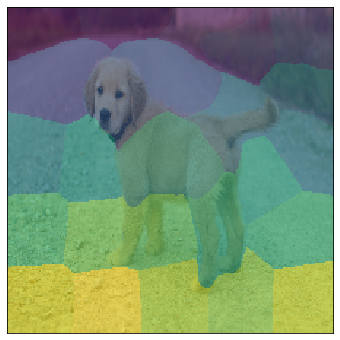

In [54]:
pl.figure(figsize=(6,6))
fig = pl.imshow(segments_slic);
pl.imshow(img,alpha=0.4)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [55]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [64]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,N_Segm)))
shap_values = explainer.shap_values(np.ones((1,N_Segm)), nsamples=60) 

  0%|          | 0/1 [00:00<?, ?it/s]/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/Users/i350114/Documents/python_env/pyth3/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is

In [65]:
# get the top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [66]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

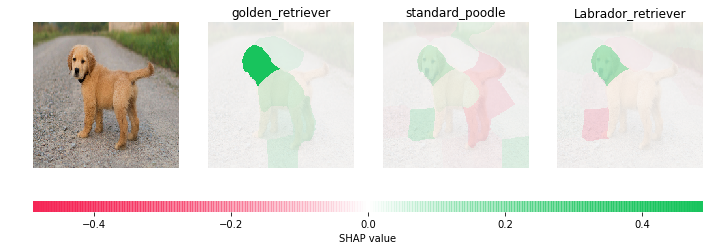

In [67]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img, alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()